# Tensorflow Tutorial

Credit: This tutorial is heavily based on a tutorial used in Berkeley's CS 294-112 course

This tutorial will provide a brief overview of the core concepts and functionality of Tensorflow. This tutorial will cover the following:

1. Creating a neural network
2. Performing computations
3. Training a neural network

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [ ]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

## 1. Creating a Neural Network

We can create neural networks using a variety of builtin tensorflow networks, including  `tensorflow.contrib.slim.fully_connected` and `tf.layers.dense`. Note that, to make the network "deep" we feed the ouput to one layer as an input to the next.

In [ ]:
tf.reset_default_graph()

# number of input features
num_features = 5

# number of output actions
num_outputs = 1

# create the placeholders
input_ph = tf.placeholder(tf.float32, [None, num_features])

# create a fully connected network layer
hidden_layer = tf.contrib.layers.fully_connected(
    input_ph,                                               # input placeholder
    32,                                                     # number of hidden nodes
    weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
    activation_fn=tf.nn.relu,                               # nonlinearity (None means linear combination)
    scope="hidden",                                         # name of the node
    reuse=tf.AUTO_REUSE)

# create an output layer
output_layer = tf.contrib.layers.fully_connected(
    hidden_layer,                                           # input placeholder
    num_outputs,                                            # number of hidden nodes
    weights_initializer=tf.truncated_normal_initializer(),  # initializer for the weights
    activation_fn=None,                                     # nonlinearity (None means linear combination)
    scope="output",                                         # name of the node
    reuse=tf.AUTO_REUSE)

## 2. Performing computations

We start by creating a tensorflow session.

In [ ]:
sess = tf.Session()

We can these execute commands by calling sess.run()

In [ ]:
a = tf.constant(1.0)
b = tf.constant(2.0)
c = a + b

c_run = sess.run(c)
print(c)
print('c = {}'.format(c_run))

If we are trying to run an operation with variables, we must first initalize the variables

In [ ]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

If we want to run commands with placeholders for inputting data, we specify an addition "feed_dict" term.

In [ ]:
numbers = np.random.randn(10,5)

res = sess.run(output_layer, feed_dict={input_ph: numbers})

print(res)

## 3. Training a neural network

We've discussed how to input data, perform operations, and create variables. We'll now show how to combine all of these---with some minor additions---to train a neural network on a simple regression problem.

First, we'll create data for a 1-dimensional regression problem:

In [ ]:
# generate the data
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, None]
outputs = np.cos(inputs) + 0.05 * np.random.normal(size=[len(inputs),1])

plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')

The below code creates the inputs, variables, neural network operations, mean-squared-error loss, gradient descent optimizer, and runs the optimizer using minibatches of the data.

In [ ]:
tf.reset_default_graph()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create a fully connected network layer
    hidden_layer = input_ph
    for i in range(3):
        hidden_layer = tf.contrib.slim.fully_connected(
            hidden_layer,
            16,
            weights_initializer=tf.truncated_normal_initializer(),
            activation_fn=tf.nn.relu,
            scope="hidden_{}".format(i),
            reuse=tf.AUTO_REUSE)

    # create an output layer
    output_layer = tf.contrib.slim.fully_connected(
        hidden_layer,
        1,
        weights_initializer=tf.truncated_normal_initializer(),
        activation_fn=None,
        scope="output",
        reuse=tf.AUTO_REUSE)
    

    return input_ph, output_ph, output_layer

input_ph, output_ph, output_pred = create_model()

# create a tensorflow session
sess = tf.Session()

# create loss
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 100
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')

Now that the neural network is trained, we can use it to make predictions:

In [ ]:
sess = tf_reset()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

plt.scatter(inputs[:, 0], outputs[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], output_pred_run[:, 0], c='r', marker='o', s=0.1)

Not so hard after all! There is much more functionality to Tensorflow besides what we've covered, but you now know the basics.

## Debugging in Tensorflow - Tensorboard
Suppose that things hadn't gone so well. How would we debug something like this? Generally, the first step will be taking advantage of tensorflows visualization tool, tensorboard. 

The first thing you want to ask is, does my computation graph look like what I expect?
Lets visualize what it looks like for the loss graph defined above. 
One very common, useful function is defined below

In [ ]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor var (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

We rebuild the network, with tags attached from variable_summaries. We also use tf.summary.scalar("scalar") to keep track of the loss. Finally, we merge all the summaries and write them to a file using

In [ ]:
tf.reset_default_graph()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create a fully connected network layer
    hidden_layer = input_ph
    for i in range(3):
        hidden_layer = tf.contrib.slim.fully_connected(
            hidden_layer,
            16,
            weights_initializer=tf.truncated_normal_initializer(),
            activation_fn=tf.nn.relu,
            scope="hidden_{}".format(i),
            reuse=tf.AUTO_REUSE)

    # create an output layer
    output_layer = tf.contrib.slim.fully_connected(
        hidden_layer,
        1,
        weights_initializer=tf.truncated_normal_initializer(),
        activation_fn=None,
        scope="output",
        reuse=tf.AUTO_REUSE)
    # Extract the weights from the output layer
    weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="output")
    # Add a summary operation to the weights
    variable_summaries(weights[0])

    return input_ph, output_ph, output_layer

input_ph, output_ph, output_pred = create_model()

# create a tensorflow session
sess = tf.Session()

# create loss
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))
tf.summary.scalar('mean_square_error', mse)

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# save the tensorboard output
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./tf_output',
                                      sess.graph)

# initialize variables
sess.run(tf.global_variables_initializer())

# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 100
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the opt step, the summaries, and the mse
    _, summary, mse_run = sess.run([opt, merged, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, '/tmp/model.ckpt')
    # save the summaries
    if training_step % 100 == 0:
        train_writer.add_summary(summary, training_step)

Now we load the tensorboard output. Go to your terminal, navigate to the folder where this notebook is located, and run `tensorboard --logdir=./tf_output`. Next open `localhost:6006:` in your browser and explore! 

A particularly useful page is the Graphs page, which you can click on at the top. Here you can see a visualization of your tensorboard graph. It's quite useful for debugging!
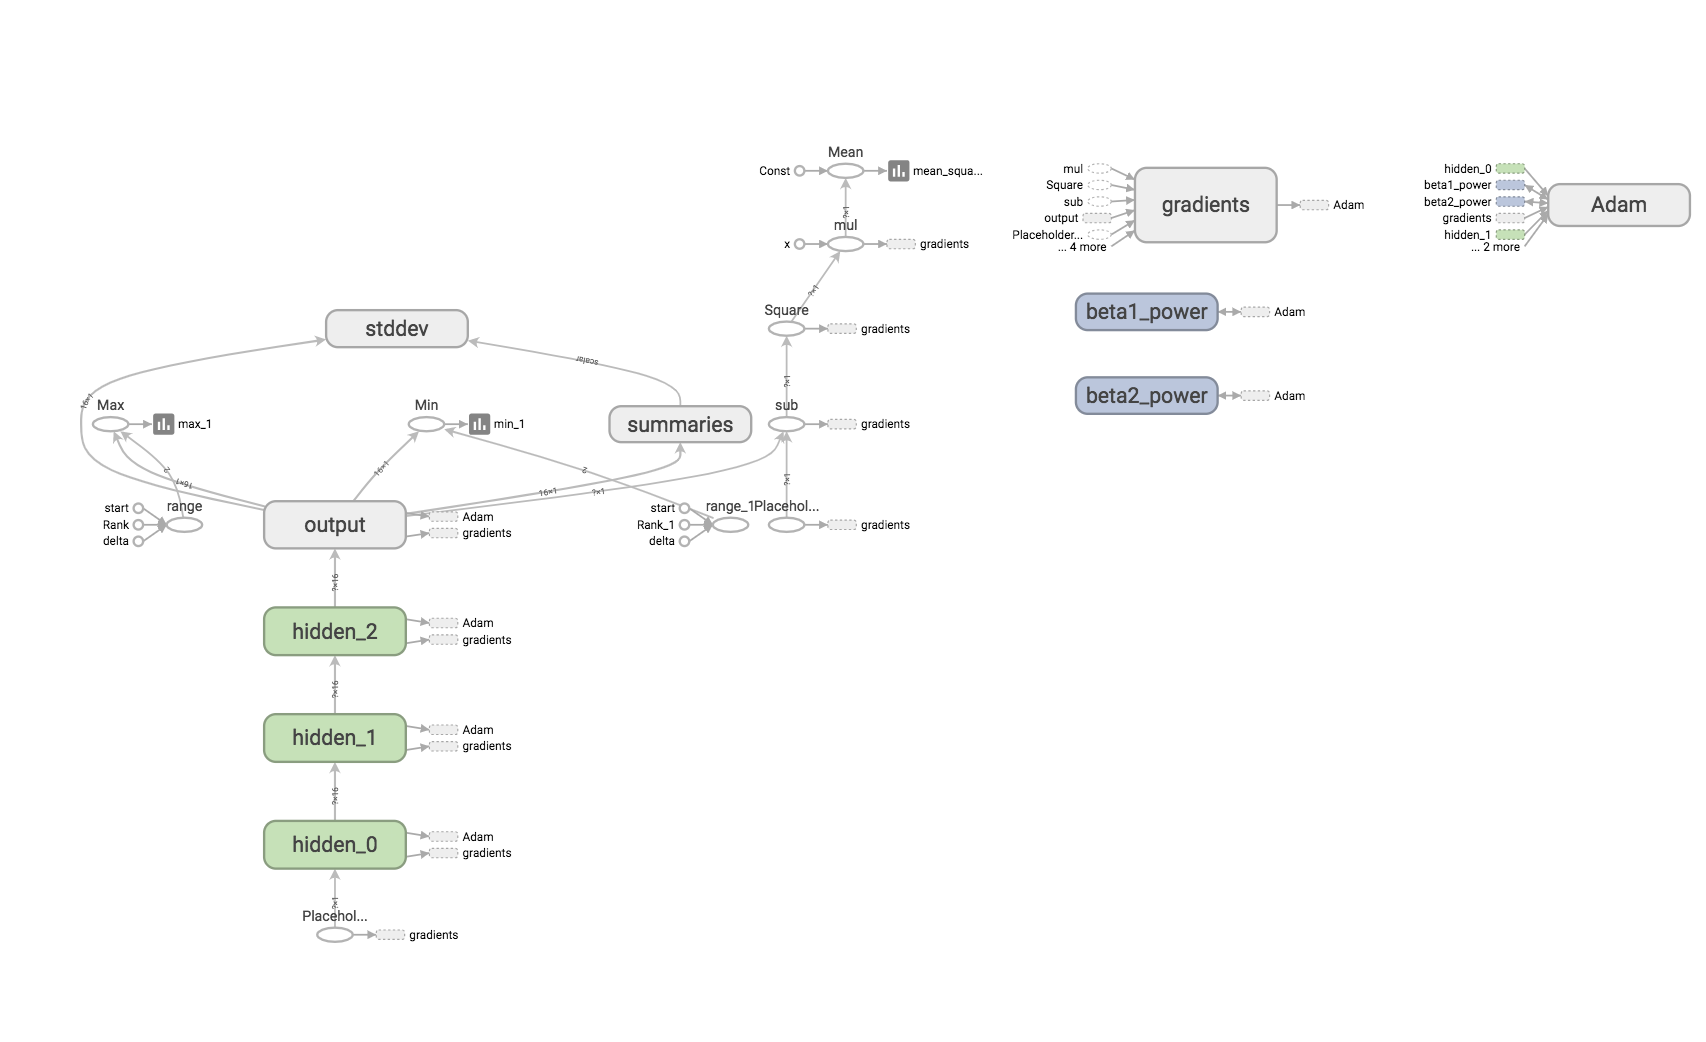

You can also check out the histograms page, where you can see a histogram of the weights for the output network. 
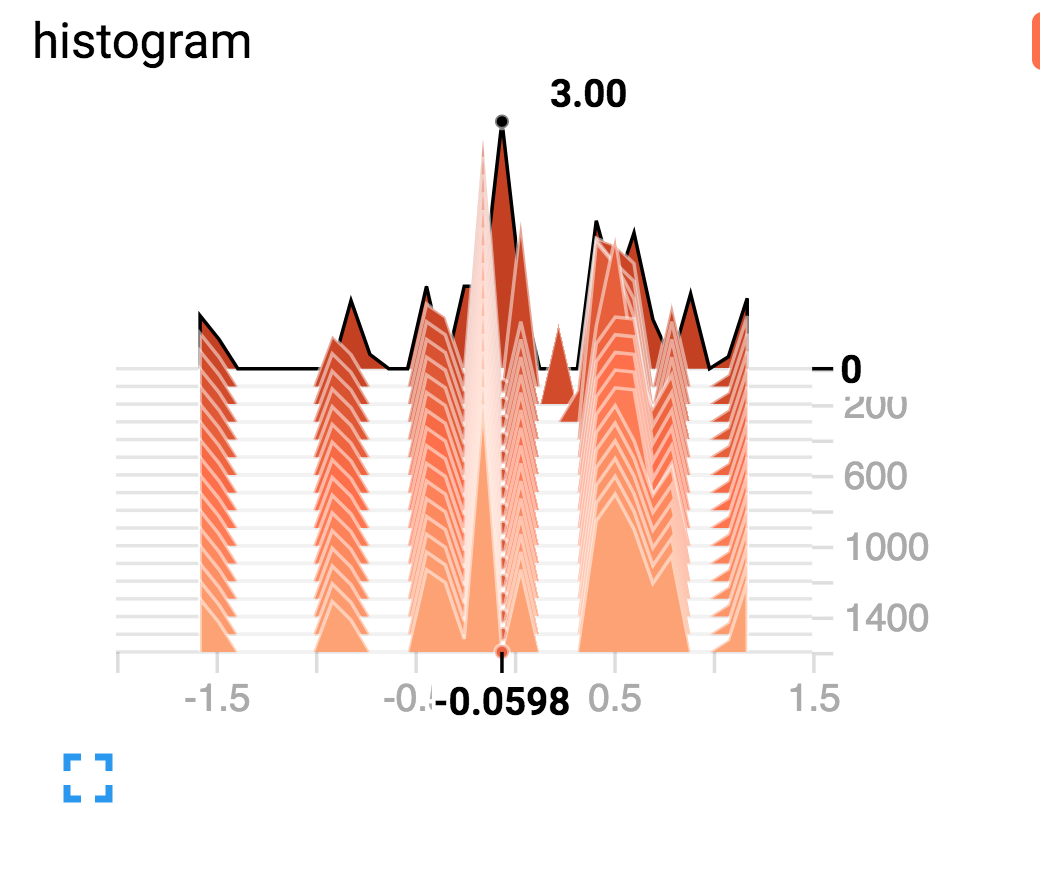

If this isn't evolving as time goes on, there's probably something wrong with your network. In particular, we initialized the weights to be roughly drawn from a normal distribution; as learning goes on they should move away and gradually become less normal.